In [19]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina

from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


In [ ]:
x, vcropoffset, h, w = (2602, 2512, 128, 128)

In [2]:
scoobi.home_block(client0)

In [3]:
scoobi.move_block_out(client0)

In [30]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='camnsv', dm_channel='dm00disp03')

In [32]:
reload(scoobi)
scoobi.create_shmim('locam_ref_0', (I.nlocam, I.nlocam))
scoobi.create_shmim('locam_ref_delta', (I.nlocam, I.nlocam))

locam_ref_0_channel = ImageStream('locam_ref_0')
locam_ref_delta_channel = ImageStream('locam_ref_delta')

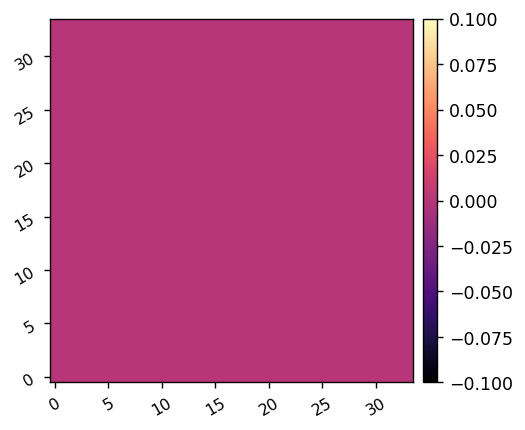

In [7]:
dh_channel = ImageStream('dm00disp05')
imshow1(dh_channel.grab_latest())
dh_channel.write(np.zeros((I.Nact,I.Nact)))

# Aquire LLOWFSC image

In [33]:
I.set_fib_atten(0, client)
I.set_nsv_gain(1, client0)
I.set_nsv_exp_time(0.0001, client0)

Set the fiber attenuation to 0.0
Set the NSV571 gain to 1.00e+00s
Set the NSV571 exposure time to 1.00e-04s


INFO:utils:Got semaphore index 1.


{'atten': 0, 'texp': 0.0001, 'gain': 1}


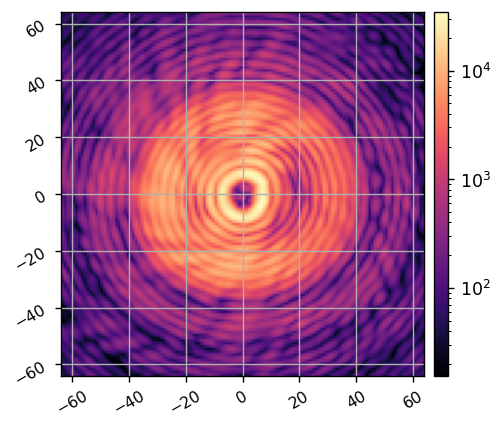

In [34]:
I.x_shift_locam = 0
I.y_shift_locam = 0
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':I.atten, 
    'texp':I.texp_locam,
    'gain':I.gain_locam,
}
print(I.ref_locam_params)

I.return_ni_locam = True
I.subtract_dark_locam = False

ref_im = I.snap_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

In [35]:
locam_ref_0_channel.write(ref_im)

# Perform LLOWFSC calibration

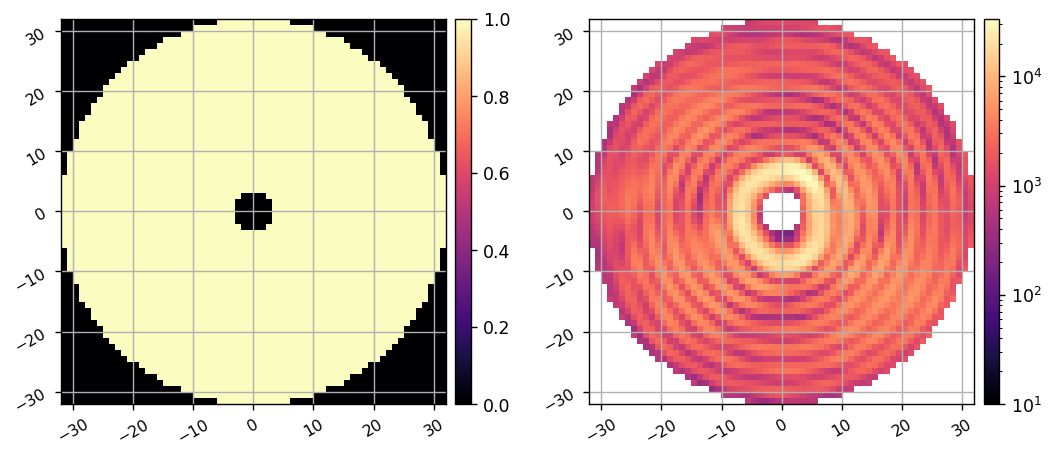

In [78]:
irad = 3
orad = 32
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

In [79]:
had_modes = ensure_np_array(lina.utils.create_hadamard_modes(xp.array(I.dm_mask)))
had_modal_matrix = had_modes.reshape(had_modes.shape[0], -1)


In [80]:
I.zero_dm()

In [81]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 20)
I.dm_delay = 0.02
had_rm = lina.llowfsc.calibrate_without_fsm(I, control_mask, dm_modes=had_modes, amps=5e-9, plot=False)

In [82]:
utils.save_fits(f'../data/{today}_llowfsc_had_rm.fits', had_rm)

Saved data to:  ../data/20241024_llowfsc_had_rm.fits


In [14]:
had_rm = ensure_np_array(utils.load_fits(f'../data/{today}_llowfsc_had_rm.fits'))

In [29]:
reload(lina.llowfsc)
lina.llowfsc.update_locam_delta(had_rm, had_modal_matrix, control_mask, dh_channel, locam_ref_delta_channel,)

In [83]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

update_freq = 100

args = [had_rm, had_modal_matrix, control_mask, dh_channel, locam_ref_delta_channel]
update_ref_process = lina.utils.Process(1/update_freq, 
                                        lina.llowfsc.update_locam_delta, 
                                        args, # the args
                                        )

In [84]:
update_ref_process.start()

In [71]:
update_ref_process.cancel()

In [89]:
dh_channel.write(0.00*had_modes[500])

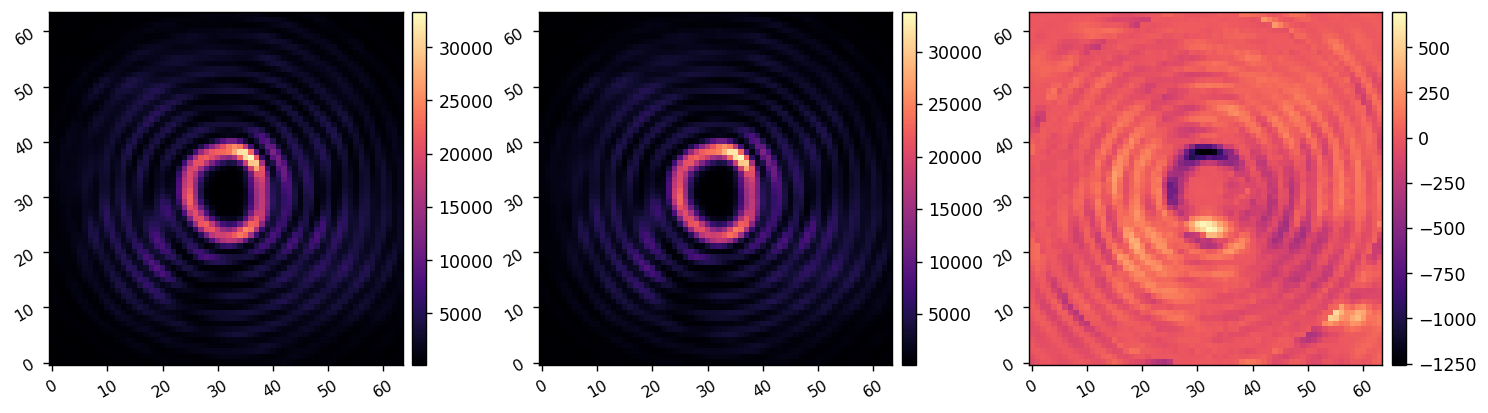

In [88]:
pred = locam_ref_0_channel.grab_latest() + locam_ref_delta_channel.grab_latest()
real = I.snap_locam()
diff = real - pred
imshow3(real, pred, diff)